In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time
import scipy.io

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

In [2]:
v98 = ulmo_io.load_main_table('s3://viirs/Tables/VIIRS_all_98clear_std.parquet')

Read main table: s3://viirs/Tables/VIIRS_all_98clear_std.parquet


In [3]:
head = v98[ (v98.datetime.dt.year > 2011) & (v98.datetime.dt.year < 2015) ]
head.shape

(941940, 20)

In [4]:
tail = v98[ (v98.datetime.dt.year > 2017) & (v98.datetime.dt.year < 2021) ]
tail.shape

(1023420, 20)

In [5]:
evts_head, hp_lons_head, hp_lats_head, meds_head = sp.evals_to_healpix_meds(eval_tbl=head, nside=64,  mask=True)

In [6]:
evts_head.dump('evts_head')
hp_lons_head.dump('hp_lons_head')
hp_lats_head.dump('hp_lats_head')
meds_head.dump('meds_head')

In [8]:
evts_tail, hp_lons_tail, hp_lats_tail, meds_tail = sp.evals_to_healpix_meds(eval_tbl=tail, nside=64,  mask=True)

In [9]:
evts_tail.dump('evts_tail')
hp_lons_tail.dump('hp_lons_tail')
hp_lats_tail.dump('hp_lats_tail')
meds_tail.dump('meds_tail')

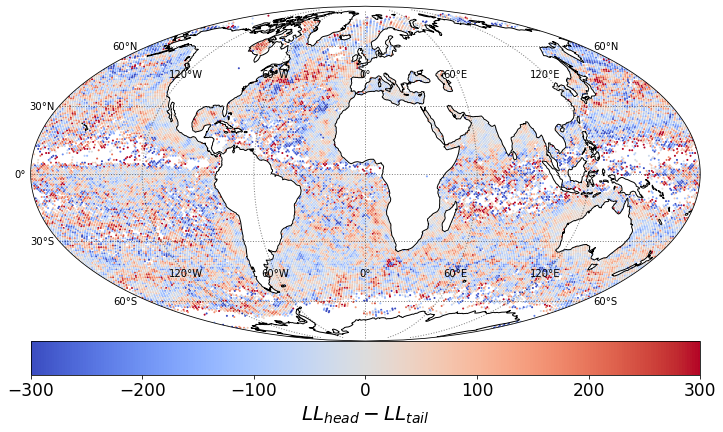

In [12]:
fig = plt.figure(figsize=(12,8))
plt.clf()

tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

ax = plt.axes(projection=tformM)

cm = plt.get_cmap('coolwarm')
# Cut
good = np.invert(evts_head.mask)
img = plt.scatter(x=hp_lons_tail[good],
    y=hp_lats_tail[good],
    c=meds_head[good]- meds_tail[good], vmin = -300, vmax = 300, 
    cmap=cm,
    s=1,
    transform=tformP)

# Colorbar
cb = plt.colorbar(img, orientation='horizontal', pad=0.)
clbl = r'$LL_{head} - LL_{tail}$'
cb.set_label(clbl, fontsize=20.)
cb.ax.tick_params(labelsize=17)

# Coast lines

ax.coastlines(zorder=10)
ax.set_global()

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
    color='black', alpha=0.5, linestyle=':', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
#gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
#gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
#gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])
plt.savefig('med_LL_diff_head_vs_tail', dpi = 600)

# Variability in measurement as a function of number of fields

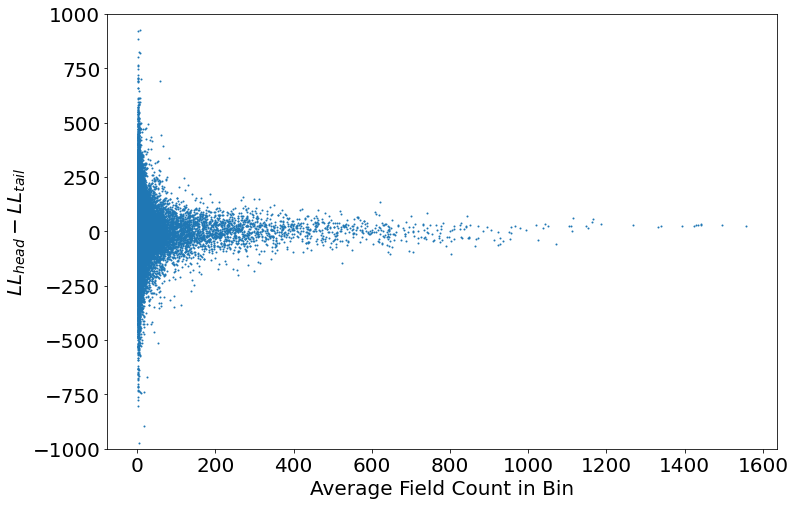

In [22]:
# Figure
fig = plt.figure(figsize=(12,8))
plt.clf()

# Cut
a = meds_head.mask == False
b = meds_tail.mask == False
c = a & (a==b)

ax = plt.scatter(x= np.mean(np.array([evts_head[c], evts_tail[c]]), axis=0), y = meds_head[c]- meds_tail[c], s=1)

# Axis Labels
plt.xlabel('Average Field Count in Bin', fontsize = 20)
plt.ylabel(r'$LL_{head} - LL_{tail}$', fontsize = 20)
plt.ylim(-1000, 1000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('Variability_med_LL_diff_head_vs_tail', dpi = 600)

In [19]:
np.mean(np.array([evts_head[c], evts_tail[c]]), axis=0)

array([3. , 2.5, 7.5, ..., 4.5, 1.5, 4.5])

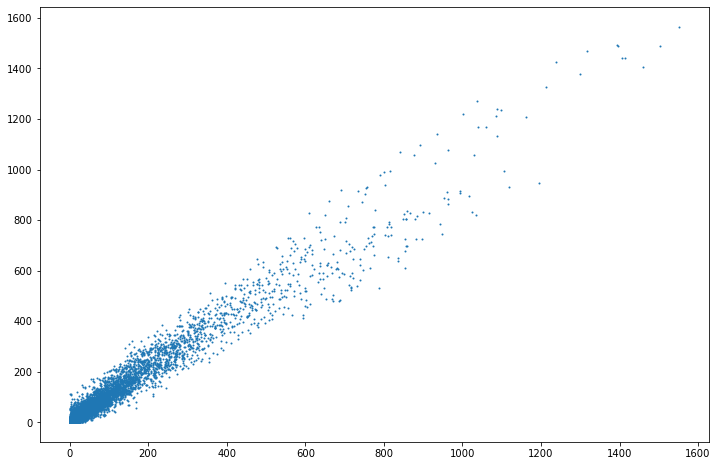

In [14]:
# Figure
fig = plt.figure(figsize=(12,8))
plt.clf()

# Cut
a = meds_head.mask == False
b = meds_tail.mask == False
c = a & (a==b)

ax = plt.scatter(x= evts_head[c] , y = evts_tail[c], s=1)